# Analysis and Classification of News Articles 
## Data Sciene I

### Project by Hicham Saddiki (6056456) and Fabian Ulmer (6264086)

**Pre-requirements** <br>
In this phase, all required libraries are imported, structured loosely by their application in our end-to-end pipeline.

In [197]:
# Fundamental Data Science 
import pandas as pd
import numpy as np
import json
import random
import time
import os

# Data Cleaning
import bs4
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from bs4 import BeautifulSoup
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Model Building and Training
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn import metrics

# Plotting and Visualization
import seaborn as sn
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Evaluation Insights
# AIX360
from aix360.algorithms.lime import LimeTextExplainer
from sklearn.pipeline import make_pipeline
# Interpret
from interpret import show
from interpret.glassbox import ClassificationTree


[nltk_data] Error loading punkt: <urlopen error [Errno 8] nodename nor
[nltk_data]     servname provided, or not known>
[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


# I. Data Pre-processing
1. Data Preparation
2. Data Merging
3. Data Cleaning <br>
4. [Digression:] Data Analysis & Insights 
5. Vectorization & Data Splitting

## 1. Data Preperation
In this phase, our two datasets are loaded into the notebook. These are:
    -  BBC Dataset News Classification by "Science Foundation Ireland" at University College Dublin
       --> 
       Link: http://mlg.ucd.ie/datasets/bbc.html
    -  TagMyNews Datset by "Algortihm and Application Lab" at University of Pisa
       --> ca. 32,000 news items extracted from RSS feeds 
       --> we used an excerpt consisting of ca. 1,400 news items
       Link: https://github.com/vijaynandwani/News-Classification
    
Optionally a third dataset can be used (utilized for the compactized work at the end):
    - News Category Dateset from HuffPost
    - Link: https://www.kaggle.com/rmisra/news-category-dataset

In [216]:
# Read in the datasets
#- D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006.

path1 = ''
path2 = 'Datasets/TMN.csv'

try:
    path1 = 'Datasets/bbc-fulltext/bbc/'
    def readIn(path):
        """
        Read in txt files from a labelled directory structure
        Return a dataframe with labels as columns
        """
        directories = [d for d in os.listdir(path)]
        news, newstype = [], []

        for d in directories:
            path_d = path+d+'/'
            for f in os.listdir(path_d):
                # use "rb" instead of "r" because of UnicodeDecodeError
                with open (path_d + f, "r") as textfile:
                    news.append(textfile.read())
                    newstype.append(d)

        df = pd.DataFrame(list(zip(news, newstype)), 
                          columns =['news', 'type'])

        return df

    df1 = readIn(path1)
except:
    path1 = 'Datasets/BBCNewsBig.csv'
    df1 = pd.read_csv(path1)
    
df2 = pd.read_csv(path2)

# Shuffle the DataFrames 
df1 = df1.sample(frac=1, random_state=96)
df2 = df2.sample(frac=1, random_state=96)

print(df1.shape)
print(df2.shape)

(2225, 3)
(1433, 3)


## 2. Data Merging
In this phase, a short sample of our datasets is shown. Then, the datasets are merged based on their common denominator: news text data & categorical news type; here denotes as *news* & *type* for df1 and *data* & *flag* for df2

In [217]:
df1.head(3)

,Unnamed: 0,news,type
1226,1226,Blair joins school sailing trip\n \n The prime...,politics
941,941,Research fears over Kelly's views\n \n Scienti...,politics
697,697,John Peel replacement show begins\n \n The per...,entertainment


In [218]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2225 entries, 1226 to 2132
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2225 non-null   int64 
 1   news        2225 non-null   object
 2   type        2225 non-null   object
dtypes: int64(1), object(2)
memory usage: 69.5+ KB


In [127]:
df1.head(3)

,Unnamed: 0,news,type
1226,1226,Blair joins school sailing trip\n \n The prime...,politics
941,941,Research fears over Kelly's views\n \n Scienti...,politics
697,697,John Peel replacement show begins\n \n The per...,entertainment


In [128]:
df2.head(3)

,Unnamed: 0,data,flag
208,208,nba insider: mavs' coach rick carlisle credits...,0
604,604,venezuela oil tax to net billions before chave...,1
540,540,"a trial in brazil, with testimony on long isla...",1


In [219]:
# Rename the dataframes' colums for uniformity
df1.rename(columns={'news':'text',
                        'type': 'category'},inplace=True)
df2.rename(columns={'data':'text',
                      'flag':'category'}, inplace=True)

# Delete unneccesary column (unnamed id) in df2
try:
    del df1['Unnamed: 0']
except:
    pass
try:
    del df2['Unnamed: 0']
except:
    pass

print(f"Relevant columns of first df1 now match those of df2 \ndf1: {list(df1.columns)} <-> df2: {list(df2.columns)}")

Relevant columns of first df1 now match those of df2 
df1: ['text', 'category'] <-> df2: ['text', 'category']


In [221]:
# Merge df1 and df2
df1_text = df1["text"]
df2_text = df2["text"]

df1_label = df1["category"]
df2_label = df2["category"]
# Labels for df2 taken from ... 

df2_label = (df2_label.replace({0: 'sport', 
                                1: 'world',
                                2: 'us',
                                3: 'business',
                                4: 'health',
                                5: 'entertainment',
                                6: 'tech'
                                })).values

# Change the discrete classes to strings
df2['category'] = df2_label

# Merge the uncleaned merge
df1_exp = pd.DataFrame(list(zip(df1_text, df1_label)), 
                          columns =['text', 'category']) 
df2_exp = pd.DataFrame(list(zip(df2_text, df2_label)), 
                        columns =['text', 'category'])
df = pd.concat([df1_exp, df2_exp])
#{'business':0, 'tech':1, 'politics':2, 'sport':3, 'entertainment':4}
#category_list = ["sport", "world", "us", "business", "health", "entertainment", "sci_tech"]

# Generate a discretized representation for each class
df['category_id'] = df['category'].factorize()[0]

# Show merged dataframe
df.head(3)


,text,category,category_id
0,Blair joins school sailing trip\n \n The prime...,politics,0
1,Research fears over Kelly's views\n \n Scienti...,politics,0
2,John Peel replacement show begins\n \n The per...,entertainment,1


**Plot of category sizes**

Text(0, 0.5, 'number of examples')

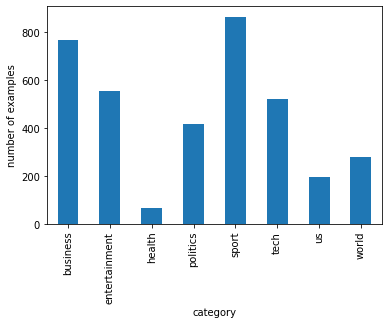

In [222]:
# Extract the category representation
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')

# Plot the class distribution for data quality
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)
df.groupby('category').category_id.count().plot.bar(ylim=0)
plt.ylabel('number of examples')

In [223]:
# Get the exact number of examples for each category
df.groupby(['category']).size()

category
business         766
entertainment    553
health            66
politics         417
sport            863
tech             519
us               194
world            280
dtype: int64

In [224]:
print(df.groupby(['category']).size().iloc[0])
print(df.groupby(['category']).grouper.labels[0])

766


AttributeError: 'BaseGrouper' object has no attribute 'labels'

In [225]:
# TODO
df.groupby(['category']).size().tolist()
#categorysizes = list(zip(df['category'].unique().tolist(), df.groupby(['category']).size().tolist()))
#print(categorysizes)

[766, 553, 66, 417, 863, 519, 194, 280]

TODO As we can see, the class "health" is underrepresented.
For this work, we drop this class.
But we took an approach to extract health-examples out of a third dataset. This is implemented at the end of this notebook.

Text(0, 0.5, 'number')

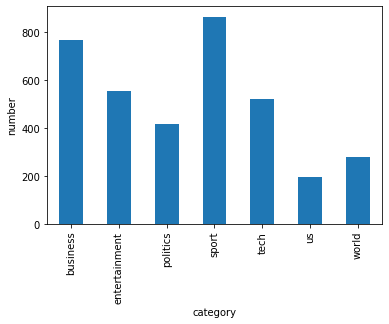

In [227]:
# Drop the underrepresented category
df = df[df.category != 'health']

# Extract the category representation
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')

# Plot the class distribution for data quality
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)
df.groupby('category').category_id.count().plot.bar(ylim=0)
plt.ylabel('number')

In [228]:
# Export merged dataframe to csv file
df.to_csv('TMN_BBC.csv', index=False)
print("Export completed")

Export completed


## 3. Data Cleaning
In this phase, 2 cleaning methods with several cleaning techniques are applied
1. Fundumental Cleaning
    - NaN values
    - duplicates
2. Syntactical Cleaning
    - tags
    - words
    - punctuation
    
Fundamental Cleaning involves data pre-processing steps that with a scarce chance to effect further analysis negatively. In fact, the two techniques can be seen as mandatory to reduce unwanted bias in the dataset and likely produce a better outcome. The possible negative impact can be reduced to chance. <br>
Syntactical Cleaning involves pre-procesing steps whose influence on the predictive models is part of the evaluation

**Fundamental Cleaning**

In [96]:
# Check if there are any NaN values in the dataframe
# Alternatively isnull() can be used, for a differentiaten see: https://datascience.stackexchange.com/questions/37878/difference-between-isna-and-isnull-in-pandas
df.isna().values.any()

False

In [97]:
# Check if duplicate values in the text column exist
df.duplicated(keep='first').any()

True

In [98]:
# Drop all duplicate entries in the dataframe
print(f"number of duplicates: {df['text'].count()-df['text'].nunique()} = ({df['text'].count()} - {df['text'].nunique()}) aka (total number of entries - unique entries)")
df.drop_duplicates(subset ='text', keep = 'first', inplace = True) 

number of duplicates: 113 = (3592 - 3479) aka (total number of entries - unique entries)


In [99]:
# Check again for duplicates
print(f"number of duplicates: {df['text'].count()-df['text'].nunique()} = ({df['text'].count()} - {df['text'].nunique()}) aka (total number of entries - unique entries)")
df.duplicated(keep='first').any()

number of duplicates: 0 = (3479 - 3479) aka (total number of entries - unique entries)


False

**Syntactical Cleaning**

In [26]:
example_text = "BrEaKinG wasn't News!! I'm was not plays Sports & 99 referees ? / our communities. ]"
#print(clean_text(example_text))

Lowercase the text

In [27]:
print(example_text)
example_text = example_text.lower().strip()
print(example_text)


BrEaKinG wasn't News!! I'm was not plays Sports & 99 referees ? / our communities. ]
breaking wasn't news!! i'm was not plays sports & 99 referees ? / our communities. ]


Remove punctuations and special characters

In [28]:
print(s)
example_text_sub = re.sub('\.+|!+|\?+', ' ', s)
example_text_sub = re.sub('[^\'a-z\.]+', ' ', example_text_sub)
#example_text_sub = re.sub('[^a-zA-Z.]', ' ', example_text_sub)
example_text_sub = ' '.join(example_text_sub.split())
print(example_text_sub)


NameError: name 's' is not defined

Lemmatize the the text

In [29]:
lemmatizer = WordNetLemmatizer()
text = [lemmatizer.lemmatize(token) for token in example_text_sub.split(' ')]
print(text)

NameError: name 'example_text_sub' is not defined

In [30]:
text = 'Possibilities with communities and so on'
text = [lemmatizer.lemmatize(token) for token in text.split(' ')]
text 

['Possibilities', 'with', 'community', 'and', 'so', 'on']

In [1682]:
print(example_text_sub)

breaking news i am wasn't playing sports and referees our communities


In [1683]:
import spacy
nlp = spacy.load('en_core_web_sm')

doc = nlp("u" + example_text)
print(doc.sents)
print(doc[4].lemma_)
for token in doc:
    print(token, token.lemma, token.lemma_)

!
ubreaking 12230158337809906929 ubreaking
was 10382539506755952630 be
n't 447765159362469301 not
news 7614825220766900367 news
! 17494803046312582752 !
! 17494803046312582752 !
i 561228191312463089 -PRON-
'm 10382539506755952630 be
was 10382539506755952630 be
not 447765159362469301 not
plays 8228585124152053988 play
sports 13020240661013469444 sports
& 15473034735919704609 &
99 2109122447810884487 99
referees 584641706835405091 referee
? 8205403955989537350 ?
/ 2466615745961202537 /
our 561228191312463089 -PRON-
communities 17822516981717808594 community
. 12646065887601541794 .
] 3806482680584466996 ]


In [156]:
# Clean the dataset syntactically
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(textToClean): 
    
    """
    takes a string and returns its cleaned version
    """
    # remove all tags with parser
    soup = BeautifulSoup(textToClean, "html.parser")
    text = soup.get_text()
    
    # lowercase text and remove leading/trailing spaces
    text = text.lower().strip()
    
    # map puncuation; leadiing space w.r.t to lemmatization
    text = re.sub('\.+|!+|\?+', ' ', text)
    
    # decontract words (was'nt --> was not)
    # https://stackoverflow.com/questions/43018030/replace-apostrophe-short-words-in-python
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)

    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    
    # remove further characters with scarce sentiment affnity
    text = re.sub('[^\'a-z\.]+', ' ', text)
    
    # remove unneccesary blanks
    text = ' '.join(text.split())
    
    # remove stop words
    text = text.split(" ")
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    
    # lemmatize each word 
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = " ".join(text)
    
    return text

# Apply syntactcal cleaning to dataframe, resulting in dfc; (keep original dataframe)
dfc = df.copy()
dfc['text'] = dfc['text'].apply(lambda x: clean_text(x))

In [157]:
print(f"Example exerpt of an uncleaned text in the dataframe:\n'{df['text'].iloc[5]}'")
print('_____________________________________________________________________________________________________________________\n')
print(f"Example exerpt of a cleaned text in the dataframe:\n'{dfc['text'].iloc[5]}'")


Example exerpt of an uncleaned text in the dataframe:
'El Guerrouj targets cross country
 
 Double Olympic champion Hicham El Guerrouj is set to make a rare appearance at the World Cross Country Championships in France.
 
 But the Moroccan, who has not raced over cross country for 15 years, will not decide until two weeks before the event which starts on 19 March. "If I am to compete in it, it is only if I feel I can win," said the 30-year-old, who is retiring in 2006. "Otherwise there is not much point in me going." El Guerrouj achieved a lifetime ambition last August when he clinched his first Olympic titles over 1500m and 5,000m. But the four-time world 1500m champion is still hungry for more success before calling time on his career. The 30-year-old has set his sights on clinching the world 5,000m crown in Helsinki this summer. And he is aiming to break 10,000m Olympic champion Kenenisa Bekele's 5,000m and 10,000m world records.
 
 El Guerrouj could meet Bekele in March as the Ethi

## 4. Data Analysis & Insights 
i. Total Word count before and after syntacial Data Cleaning <br>
ii. Term Frequency, Inverse Document Frequency of all words, essential words <br>
iii. WordCloud


**i) Word Count**

In [158]:
# Get number of words in a dataframe

def getwordcount(dataframe):
    """
    Computes the number of total and unique words for a dataframe.
    Note, dataframe *must* have a 'text' column with the text to be counted.
    """
    words = []
    text = dataframe["text"].tolist()
    for entry in text:
        entry_words = entry.split(" ") # temp list of words for each entry row
        for word in entry_words:
            words.append(word)
    words_total = len(words)
    words_unique= len(set(words))
    return words_total, words_unique

words_total_df, words_unique_df = getwordcount(df)
print('The merged dataset consists of ' + str(words_total_df) + ' words')
print('The merged dataset consists of ' + str(words_unique_df) + ' unique words')

words_total_dfc, words_unique_dfc = getwordcount(dfc)
print('The cleaned and merged dataset consists of ' + str(words_total_dfc) + ' words')
print('The cleaned and merged dataset consists of ' + str(words_unique_dfc) + ' unique words')

The merged dataset consists of 910828 words
The merged dataset consists of 74455 unique words
The cleaned and merged dataset consists of 516688 words
The cleaned and merged dataset consists of 27519 unique words


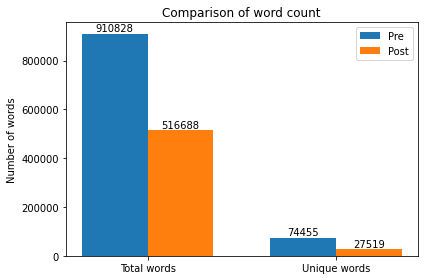

In [159]:
# Visualize number of words in a dataframe
labels = ['Total words','Unique words']
pre = [words_total_df, words_unique_df] #912968 74650
post = [words_total_dfc, words_unique_dfc] 
#bar(x, y, width=30)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, pre, width, label='Pre')
rects2 = ax.bar(x + width/2, post, width, label='Post')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of words')
ax.set_title('Comparison of word count')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 0),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

**ii) TF-IDF**

In [105]:
textlist = df['text'].tolist()
textlist_cleaned = dfc['text'].tolist()

In [107]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [108]:
# CountVectorizer for the uncleaned DataFrame
cv_uncleaned=CountVectorizer()
count_vector_uncleaned=cv_uncleaned.fit_transform(textlist)
print(count_vector_uncleaned.shape)
# CountVectorizer for the cleaned DataFrame
cv_cleaned=CountVectorizer()
count_vector_cleaned=cv.fit_transform(textlist_cleaned)
print(count_vector_cleaned.shape)


(3479, 31292)


NameError: name 'cv' is not defined

In [1692]:
# TfidfTransformer for the uncleaned DataFrame
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [1693]:
# print idf values
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"])
 
# sort ascending
df_idf.sort_values(by=['idf_weights']) # the lower the score, the less unique --> more often in a text (idf_weight = 0 --> in every text)

,idf_weights
said,1.559903
year,1.819806
also,2.052288
would,2.082366
one,2.150813
...,...
joly,8.461640
jonatan,8.461640
jonesboro,8.461640
jongleur,8.461640


In [1651]:
# print idf values
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"])
 
# sort ascending
df_idf.sort_values(by=['idf_weights']) # the lower the score, the less unique --> more often in a text (idf_weight = 0 --> in every text)

,idf_weights
said,1.559903
year,1.819806
also,2.052288
would,2.082366
one,2.150813
...,...
joly,8.461640
jonatan,8.461640
jonesboro,8.461640
jongleur,8.461640


**iii) WordCloud**

Visualization of newsitem number 50's significance. The bigger the word, the more important it is.
Change newsitem number between 0 and 3591

This example refers to a sport-article.


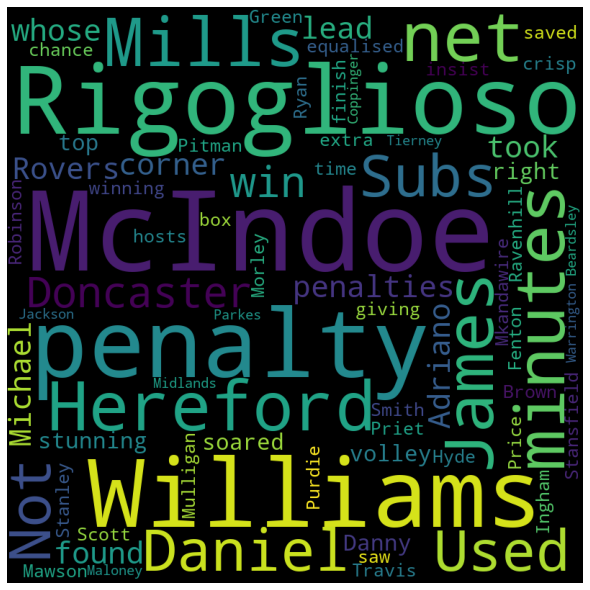

In [160]:
# Visualize the significance of important words

# Change newsItem to see different word clouds
newsItem = 50 

wordcloud_instance = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords=None,
                min_font_size = 10).generate(df['text'].iloc[newsItem])           
plt.figure(figsize = (8, 8), facecolor = None) 

print(f"Visualization of newsitem number {newsItem}'s significance. The bigger the word, the more important it is.\nChange newsitem number between 0 and {len(df)-1}")
print()
print('This example refers to a '+str(df['category'].iloc[newsItem]) + '-article.')
plt.imshow(wordcloud_instance) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()




## 5. Vectorization and Data Splitting

In [110]:
# Export the cleaned and merged dataframe to csv file
df.to_csv('TMN_BBC_cleaned.csv', index=False)
print('Export completed')

Export completed


**Vectorization with TfidVectorizer**

In [243]:
# Take the cleaned dataset
df = dfc
# Use TfidVectorizer for a vectorized representation of each word
tfidf = TfidfVectorizer(sublinear_tf=True, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english', max_features=15000)
features = tfidf.fit_transform(df.text).toarray() 
labels = df.category_id 



**Data Splitting by means of sklearn framework**

In [244]:
# Split into train and test data with a 70%/30% distribution
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)


# II. Model Building & Training

**Build and train the following models**
1. Random Forrest
2. Decision Tree

Evaluate Models using the following sklearns metrics:**
- Accuracy
- F1-Score
- Precision
- Recall

## 1. Random Forest Model

Accuracy of the RandomForestClassifier: 0.8208955223880597
F1-Score of the RandomForestClassifier: 0.7723318010383229
Precision of the RandomForestClassifier: 0.8280104034777744
Recall of the RandomForestClassifier: 0.7707750438716483



Text(0.5, 1.0, 'Confusion Matrix')

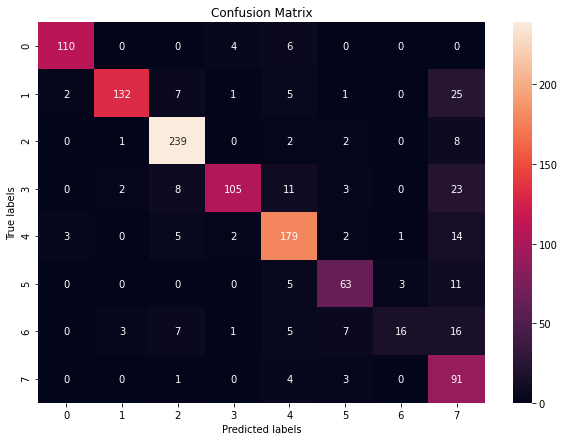

In [248]:
rfc = RandomForestClassifier()
# Train XGBClassifier
rfc.fit(X_train, y_train)
# Predict the response for test dataset
y_pred_rfc = rfc.predict(X_test)

print("Accuracy of the RandomForestClassifier:",metrics.accuracy_score(y_test, y_pred_rfc))
print("F1-Score of the RandomForestClassifier:",metrics.f1_score(y_test, y_pred_rfc, average="macro"))
print("Precision of the RandomForestClassifier:",metrics.precision_score(y_test, y_pred_rfc, average="macro"))
print("Recall of the RandomForestClassifier:",metrics.recall_score(y_test, y_pred_rfc, average="macro")) 
print()
categories = df['category'].unique()
# Build the Confusion Matrix
cm=metrics.confusion_matrix(y_test,y_pred_rfc)
plt.figure(figsize = (10,7))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(categories); ax.yaxis.set_ticklabels(categories, rotation="0")



## 2. Decision Tree Model

In [65]:
dt = DecisionTreeClassifier()
# Train XGBClassifier
dt.fit(X_train, y_train)
# Predict the response for test dataset
y_pred_dt = dt.predict(X_test)

print("Accuracy of the DecisionTreeClassifier:",metrics.accuracy_score(y_test, y_pred_dt))
print("F1-Score of the DecisionTreeClassifier:",metrics.f1_score(y_test, y_pred_dt, average="macro"))
print("Precision of the DecisionTreeClassifier:",metrics.precision_score(y_test, y_pred_dt, average="macro"))
print("Recall of the DecisionTreeClassifier:",metrics.recall_score(y_test, y_pred_dt, average="macro")) 

Accuracy of the DecisionTreeClassifier: 0.7212643678160919
F1-Score of the DecisionTreeClassifier: 0.6587589780892652
Precision of the DecisionTreeClassifier: 0.6587325123934261
Recall of the DecisionTreeClassifier: 0.660499050385414


# III. Result Explanation 
1. Microsoft AIX360
2. IBM InterpretML

## 1. Micosoft AIX360
Using AIX360 tool to understand and comprehend the models predictions.
It shows us the probability distribution for the prediction of example 2002.
We get information about which attributes had the influence on the final decision of the model.

In [114]:
classes = df['category'].unique()
c = make_pipeline(tfidf, rfc)
#Explain text classifiers with LimeTextExplainer
limeexplainer = LimeTextExplainer(class_names = classes)
x = 2002
#explanation of the assignment of a specific data point for Random Forest
ex_rf = limeexplainer.explain_instance(df['text'].iloc[x], c.predict_proba, top_labels=2, num_features=5)
ex_rf.show_in_notebook(text=df['text'].iloc[x])


## 2. IBM InterpretML
This approach can give us an illustration of how the decision tree handles the extracted features.
The upper picklist lists all test examples. By clicking on an example, the decision tree and its way to the leaf get visualized


In [115]:
#Interpret ML approach
#Create the explainable classifier from InterpretML
dti = ClassificationTree()
#Train the classifier
dti.fit(X_train, y_train)
#Let the classifier predict
y_pred_dti=dti.predict(X_test)
dti_local = dti.explain_local(X_test, y_test)
show(dti_local)


<!-- http://127.0.0.1:7551/5021511568/ -->

# ------------------------------------------------------------------------------------------

# IV. NewsCategorizer Class
The following class compactizes our pipeline. The data-preparation as well as the evalution of the two models can be called with different input datasets <br>
Compactize our work in a pipeline that we have built

In [236]:
class NewsCategorizer():
    
    def __init__(self, models, df):
        self.models = models
        self.df = df
        self.dfCleaned = None
        self.dfCleanedExpanded = None
        self.dfScaPy = None
        
    def datasetVariations(self): 
        """
        method to construct the different dataset variations
        just merged dataset
        cleaned and merged dataset
        cleaned and merged dataset and expanded with added health examples
        """
        # Define the stopwords and the lemmatizer instance
        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()
        
        # Construct the cleaned dataset (BBCNews & TagMyNews)
        self.dfCleaned = df.copy()
        self.dfCleaned.drop_duplicates(subset ='text', keep = 'first', inplace = True) 
        self.dfCleaned['text'] = self.dfCleaned['text'].apply(lambda x: self.cleanText(x, stop_words, lemmatizer))
        
        # Drop the health column in the cleaned dataset 
        self.dfCleaned = self.dfCleaned[self.dfCleaned.category != 'health']
        
        # Export cleaned dataframe without health to csv file
        self.dfCleaned.to_csv('TMN_BBC_cleaned.csv', index=False)
        print('Cleaned dataset constructed')
        
        # Construct the cleaned dataset with added health example
        thirdDf = pd.read_csv('helpingDataset.csv') 
        self.dfCleanedExpanded = pd.concat([self.df, thirdDf])
        self.dfCleanedExpanded['category_id'] = self.dfCleanedExpanded['category'].factorize()[0]
        self.dfCleanedExpanded.drop_duplicates(subset ='text', keep = 'first', inplace = True) 
        self.dfCleanedExpanded['text'] = self.dfCleanedExpanded['text'].apply(lambda x: self.cleanText(x, stop_words, lemmatizer))
        # Export expanded dataframe to csv file
        self.dfCleanedExpanded.to_csv('TMN_BBC_HEALTH_cleaned.csv', index=False)
        print('Expanded and cleaned dataset constructed (added health examples)')
        
        
    def evaluateModels(self):
        """
        evaluate the passed models based on the 
        different variations of our dataset
        """
        print('Training started with the merged dataset ')
        X_train, X_test, y_train, y_test = self.vectAndSplit(self.df)
        # Iterate through provided models
        for model in models:
            start = time.time()
            models.get(model).fit(X_train, y_train)
            stop = time.time()
            print(f"Training time: {stop - start}s")
            y_pred_model = models.get(model).predict(X_test)
            print("Accuracy of the "+ str(model) + ": " + str(metrics.accuracy_score(y_test, y_pred_model)))
            print("F1-Score of the "+ str(model) + ": " + str(metrics.f1_score(y_test, y_pred_model, average="macro")))
            print("Precision of the "+ str(model) + ": " + str(metrics.precision_score(y_test, y_pred_model, average="macro")))
            print("Recall of the "+ str(model) + ": " + str(metrics.recall_score(y_test, y_pred_model, average="macro")))
            print('')
        print('_____________________________________________________________________________________________________________________\n')


        
        
        print('Training started with the merged and cleaned dataset ')
        X_train, X_test, y_train, y_test = self.vectAndSplit(self.dfCleaned)
        # Iterate through provided models
        for model in models:
            start = time.time()
            models.get(model).fit(X_train, y_train)
            stop = time.time()
            print(f"Training time: {stop - start}s")
            y_pred_model = models.get(model).predict(X_test)
            print("Accuracy of the "+ str(model) + ": " + str(metrics.accuracy_score(y_test, y_pred_model)))
            print("F1-Score of the "+ str(model) + ": " + str(metrics.f1_score(y_test, y_pred_model, average="macro")))
            print("Precision of the "+ str(model) + ": " + str(metrics.precision_score(y_test, y_pred_model, average="macro")))
            print("Recall of the "+ str(model) + ": " + str(metrics.recall_score(y_test, y_pred_model, average="macro")))
            print('')
        print('_____________________________________________________________________________________________________________________\n')

        
        print('Training started with the expanded, merged and cleaned dataset ')
        X_train, X_test, y_train, y_test = self.vectAndSplit(self.dfCleanedExpanded)
        # Iterate through provided models
        for model in models:
            start = time.time()
            models.get(model).fit(X_train, y_train)
            stop = time.time()
            print(f"Training time: {stop - start}s")
            y_pred_model = models.get(model).predict(X_test)
            print("Accuracy of the "+ str(model) + ": " + str(metrics.accuracy_score(y_test, y_pred_model)))
            print("F1-Score of the "+ str(model) + ": " + str(metrics.f1_score(y_test, y_pred_model, average="macro")))
            print("Precision of the "+ str(model) + ": " + str(metrics.precision_score(y_test, y_pred_model, average="macro")))
            print("Recall of the "+ str(model) + ": " + str(metrics.recall_score(y_test, y_pred_model, average="macro")))
            print('')
        print('_____________________________________________________________________________________________________________________\n')

   
    
    def vectAndSplit(self, df):
        """
        vectorize the dataframe and split into train and test set
        """
        # Vectorize the dataframe
        tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', 
                                ngram_range=(1, 2), stop_words='english', max_features=15000)
        features = tfidf.fit_transform(df.text).toarray() 
        labels = df.category_id 
        
        # Split the vectorized data into training and test set
        #Split into trianieeng and test data
        X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=0)
        return X_train, X_test, y_train, y_test
        
    def cleanText(self, textToClean, stop_words, lemmatizer): 
        """
        takes a string and returns its cleaned version
        """
        # remove all tags with parser
        soup = BeautifulSoup(textToClean, "html.parser")
        text = soup.get_text()
        # lowercase text and remove leading/trailing spaces
        text = text.lower().strip()
        # map puncuation; leadiing space w.r.t to lemmatization
        text = re.sub('\.+|!+|\?+', ' ', text)
        # decontract words (was'nt --> was not)
        # https://stackoverflow.com/questions/43018030/replace-apostrophe-short-words-in-python
        text = re.sub(r"won\'t", "will not", text)
        text = re.sub(r"can\'t", "can not", text)
        # general
        text = re.sub(r"n\'t", " not", text)
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'s", " is", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r"\'ll", " will", text)
        text = re.sub(r"\'t", " not", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"\'m", " am", text)
        # remove further characters with scarce sentiment affnity
        text = re.sub('[^\'a-z\.]+', ' ', text)
        # remove unneccesary blanks
        text = ' '.join(text.split())
        # remove stop words
        text = text.split(" ")
        text = [word for word in text if not word in stop_words]
        text = " ".join(text)
        # lemmatize each word 
        text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
        text = " ".join(text)
        return text
    

The NewsCategorizer constructs the different data variations to evaluate with
 - TMN_BBC: TMN and BBC (without the health class)
 - TMN_BBC_cleaned: TMN and BBC cleaned (without the health class)
 - TMN_BBC_HEALTH_cleaned: TMN and BBC cleaned (with 316 added health examples)

In [234]:
# Provide the merged dataset 
df = pd.read_csv('TMN_BBC.csv') 
# Build up the models
models = {'Decision Tree':DecisionTreeClassifier(), 'Random Forest':RandomForestClassifier()}
# Instantiate NewsCategorizer object
categorizer = NewsCategorizer(models, df)
categorizer.datasetVariations()


Cleaned dataset constructed
Expanded and cleaned dataset constructed (added health examples)


In [235]:
# Evaluate the models based on the constructed dataset variations
categorizer.evaluateModels()

Training started with the merged dataset 
Training time: 9.655159950256348s
Accuracy of the Decision Tree: 0.6821493624772313
F1-Score of the Decision Tree: 0.5935899269110312
Precision of the Decision Tree: 0.6016319985401838
Recall of the Decision Tree: 0.5981376292012441

Training time: 19.918792009353638s
Accuracy of the Random Forest: 0.8451730418943534
F1-Score of the Random Forest: 0.7349756589485698
Precision of the Random Forest: 0.7883711296182805
Recall of the Random Forest: 0.7190322219703151

_____________________________________________________________________________________________________________________

Training started with the merged and cleaned dataset 
Training time: 10.726975917816162s
Accuracy of the Decision Tree: 0.7270114942528736
F1-Score of the Decision Tree: 0.6686157870823634
Precision of the Decision Tree: 0.6803813769481522
Recall of the Decision Tree: 0.6622138368694687

Training time: 12.810993909835815s
Accuracy of the Random Forest: 0.8505747126436

Construction of the helpingDataset: As we have seen, the merged dataset is relatively unbalanced <br>
At this point: extract examples from a third dataset to compensate this problem

#### Extract 250 from the third dataset and export them with the already existing 66 health examples

In [270]:
#Read in the helping dataset
thirdDf = pd.read_json('Datasets/News_Category_Dataset_Help.json',lines='True') 
thirdDf = thirdDf.replace(np.nan, '', regex=True)
thirdDf['headline_description'] =thirdDf['headline'] + " " + thirdDf['short_description']
thirdDf.rename(columns={'headline_description':'text',
                  'category':'category'}, inplace=True)
thirdTextsLabels = thirdDf["category"]
thirdTextsLabels = (thirdTextsLabels.replace({'TECH': 'tech', 
                                          'WORLD NEWS': 'world',
                                          'POLITICS': 'politics',
                                          'BUSINESS': 'business',
                                          'HEALTHY LIVING': 'health',
                                          'ENTERTAINMENT': 'entertainment',
                                         })).values
#Change the discrete classes to strings
thirdDf['category'] = thirdTextsLabels
#Delete unnecessary columns
try:
    del thirdDf['headline']
    del thirdDf['authors']
    del thirdDf['link']
    del thirdDf['short_description']
    del thirdDf['date']
except:
    pass
#Extract the exmaples we need to compensate the inbalance dataset
healthDf = thirdDf[thirdDf.category=='health'][0:250]


#Extract the already existing 66 health examples of TagMyNews
df2 = pd.read_csv('Datasets/TMN.csv')
df2.rename(columns={'data':'text',
                  'flag':'category'}, inplace=True)
df2TextsLabels = df2["category"]
df2TextsLabels = (df2TextsLabels.replace({0: 'sport', 
                                1: 'world',
                                2: 'us',
                                3: 'business',
                                4: 'health',
                                5: 'entertainment',
                                6: 'tech'
                                })).values
# Delete unnecessary column
try:
    del df2["Unnamed: 0"]
except:
    pass

# Change the discrete classes to strings
df2['category'] = df2TextsLabels
# Just take the health examples
df2 = df2[df2.category=='health']

# Concatinate the 250 new health examples and the 66 existing ones
helpDf = pd.concat([healthDf, 
                  df2], ignore_index=True)
helpDf.to_csv('helpingDataset.csv', index=False)
print('Export completed')


(316, 2)
Export completed


*Fin* <br>
Thank you for reading our notebook. Feedback or Questions are always welcome. "At least in science, the facts will always win in the end" - Jürgen Schmidhuber, 06.25.2020 